# CDFS SWIRE master catalogue

This notebook presents the merge of the various pristine catalogues to produce HELP master catalogue on CDFS SWIRE.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
0246c5d (Thu Jan 25 17:01:47 2018 +0000) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

import os
import time

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np
from pymoc import MOC

from herschelhelp_internal.masterlist import merge_catalogues, specz_merge, nb_merge_dist_plot
from herschelhelp_internal.utils import coords_to_hpidx, ebv, gen_help_id, inMoc

In [3]:
TMP_DIR = os.environ.get('TMP_DIR', "./data_tmp")
OUT_DIR = os.environ.get('OUT_DIR', "./data")
SUFFIX = os.environ.get('SUFFIX', time.strftime("_%Y%m%d"))

try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

## I - Reading the prepared pristine catalogues

In [4]:
atlas = Table.read("{}/ATLAS.fits".format(TMP_DIR))
combo = Table.read("{}/COMBO.fits".format(TMP_DIR))
#fireworks = Table.read("{}/Fireworks.fits".format(TMP_DIR))
ps1 = Table.read("{}/PS1.fits".format(TMP_DIR))
servs = Table.read("{}/SERVS.fits".format(TMP_DIR))
swire= Table.read("{}/SWIRE.fits".format(TMP_DIR))
video= Table.read("{}/VISTA-VIDEO.fits".format(TMP_DIR))
vhs= Table.read("{}/VISTA-VHS.fits".format(TMP_DIR))
des= Table.read("{}/DES.fits".format(TMP_DIR))
candels= Table.read("{}/CANDELS.fits".format(TMP_DIR))

## II - Merging tables

We first merge the optical catalogues and then add the infrared ones: PS1, COMBO, ATLAS, VIDEO, VHS, SERVS, SWIRE. Fireworks is no longer included.

At every step, we look at the distribution of the distances to the nearest source in the merged catalogue to determine the best crossmatching radius.

### PanSTARRS

In [5]:
master_catalogue = ps1
master_catalogue['ps1_ra'].name = 'ra'
master_catalogue['ps1_dec'].name = 'dec'

### Add Fireworks

We are no longer including Fireworks under Mattia's advice. I leave the code in the notebook commented out in case the user wishes to include it.

In [6]:
#nb_merge_dist_plot(
#    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
#    SkyCoord(fireworks['fireworks_ra'], fireworks['fireworks_dec'])
#)

In [7]:
# Given the graph above, we use 0.8 arc-second radius
#master_catalogue = merge_catalogues(master_catalogue, fireworks, "fireworks_ra", "fireworks_dec", radius=0.8*u.arcsec)

### Add COMBO

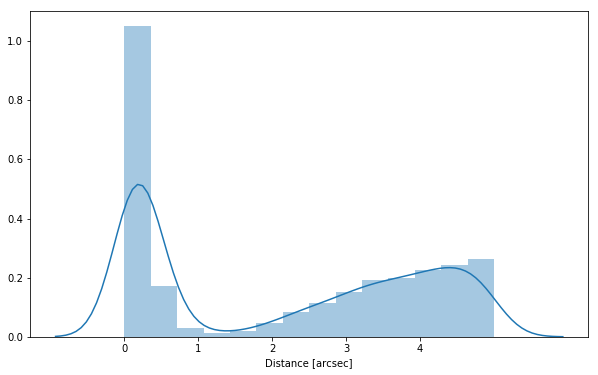

In [8]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(combo['combo_ra'], combo['combo_dec'])
)

In [9]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, combo, "combo_ra", "combo_dec", radius=0.8*u.arcsec)

### Add ATLAS

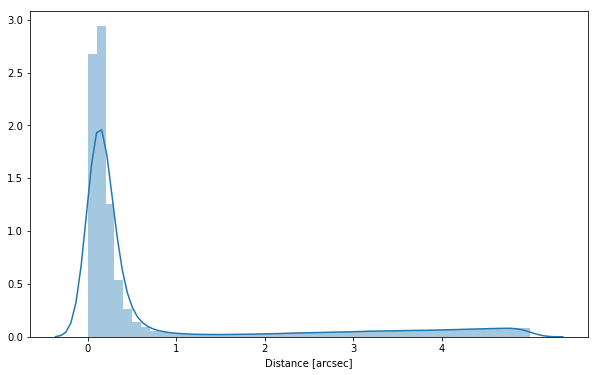

In [10]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(atlas['atlas_ra'], atlas['atlas_dec'])
)

In [11]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, atlas, "atlas_ra", "atlas_dec", radius=0.8*u.arcsec)

### Add VIDEO

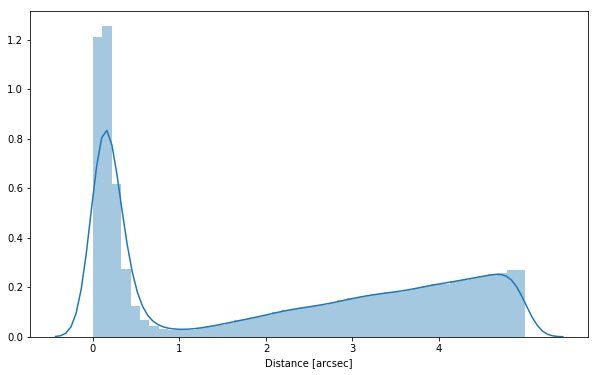

In [12]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(video['video_ra'], video['video_dec'])
)

In [13]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, video, "video_ra", "video_dec", radius=0.8*u.arcsec)

### Add VHS

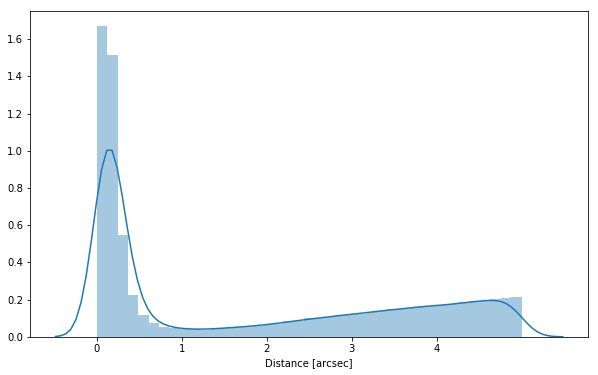

In [14]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(vhs['vhs_ra'], vhs['vhs_dec'])
)

In [15]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, vhs, "vhs_ra", "vhs_dec", radius=0.8*u.arcsec)

### Add SERVS

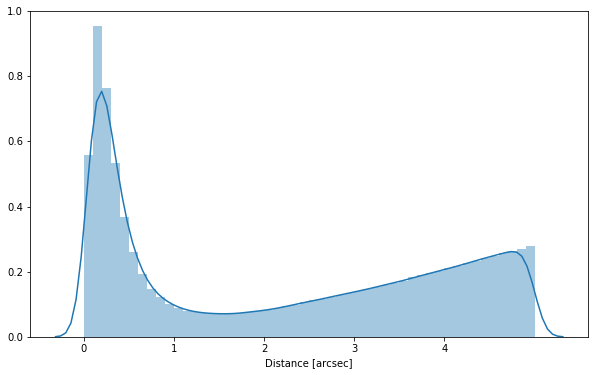

In [16]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(servs['servs_ra'], servs['servs_dec'])
)

In [17]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, servs, "servs_ra", "servs_dec", radius=1.*u.arcsec)

### Add SWIRE

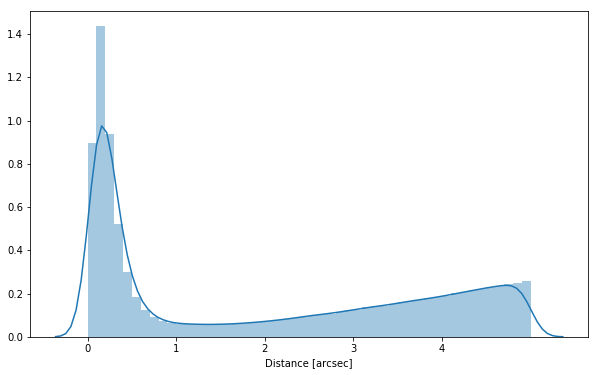

In [18]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(swire['swire_ra'], swire['swire_dec'])
)

In [19]:
# Given the graph above, we use 1 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, swire, "swire_ra", "swire_dec", radius=1.*u.arcsec)

### Add DES

DES and CANDELS are added at the end because they were not in teh original masterlist. By adding them at the end we ensure that the original HELP ids are maintained.

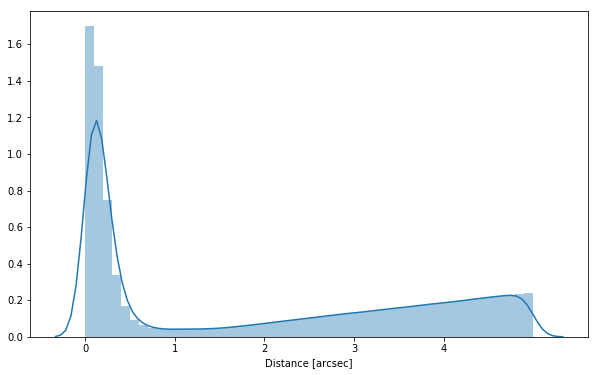

In [20]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(des['des_ra'], des['des_dec'])
)

In [21]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, des, "des_ra", "des_dec", radius=0.8*u.arcsec)

### Add CANDELS

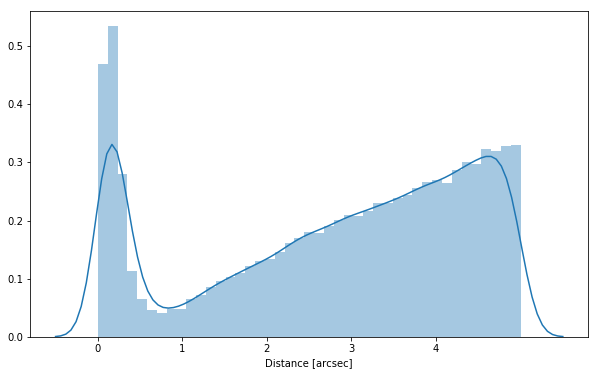

In [22]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(candels['candels_ra'], candels['candels_dec'])
)

In [23]:
# Given the graph above, we use 0.8 arc-second radius
master_catalogue = merge_catalogues(master_catalogue, candels, "candels_ra", "candels_dec", radius=0.8*u.arcsec)

### Cleaning

When we merge the catalogues, astropy masks the non-existent values (e.g. when a row comes only from a catalogue and has no counterparts in the other, the columns from the latest are masked for that row). We indicate to use NaN for masked values for floats columns, False for flag columns and -1 for ID columns.

In [24]:
for col in master_catalogue.colnames:
    if "m_" in col or "merr_" in col or "f_" in col or "ferr_" in col or "stellarity" in col:
        master_catalogue[col].fill_value = np.nan
    elif "flag" in col:
        master_catalogue[col].fill_value = 0
    elif "id" in col:
        master_catalogue[col].fill_value = -1
        
master_catalogue = master_catalogue.filled()

In [25]:
master_catalogue[:10].show_in_notebook()

idx,ps1_id,ra,dec,m_ap_ps1_g,merr_ap_ps1_g,m_ps1_g,merr_ps1_g,m_ap_ps1_r,merr_ap_ps1_r,m_ps1_r,merr_ps1_r,m_ap_ps1_i,merr_ap_ps1_i,m_ps1_i,merr_ps1_i,m_ap_ps1_z,merr_ap_ps1_z,m_ps1_z,merr_ps1_z,m_ap_ps1_y,merr_ap_ps1_y,m_ps1_y,merr_ps1_y,f_ap_ps1_g,ferr_ap_ps1_g,f_ps1_g,ferr_ps1_g,flag_ps1_g,f_ap_ps1_r,ferr_ap_ps1_r,f_ps1_r,ferr_ps1_r,flag_ps1_r,f_ap_ps1_i,ferr_ap_ps1_i,f_ps1_i,ferr_ps1_i,flag_ps1_i,f_ap_ps1_z,ferr_ap_ps1_z,f_ps1_z,ferr_ps1_z,flag_ps1_z,f_ap_ps1_y,ferr_ap_ps1_y,f_ps1_y,ferr_ps1_y,flag_ps1_y,ps1_flag_cleaned,ps1_flag_gaia,flag_merged,combo_id,combo_stellarity,m_combo_r,merr_combo_r,f_ap_combo_420,ferr_ap_combo_420,f_ap_combo_462,ferr_ap_combo_462,f_ap_combo_485,ferr_ap_combo_485,f_ap_combo_518,ferr_ap_combo_518,f_ap_combo_571,ferr_ap_combo_571,f_ap_combo_604,ferr_ap_combo_604,f_ap_combo_646,ferr_ap_combo_646,f_ap_combo_696,ferr_ap_combo_696,f_ap_combo_753,ferr_ap_combo_753,f_ap_combo_815,ferr_ap_combo_815,f_ap_combo_856,ferr_ap_combo_856,f_ap_combo_914,ferr_ap_combo_914,f_ap_combo_u,ferr_ap_combo_u,f_ap_combo_b,ferr_ap_combo_b,f_ap_combo_v,ferr_ap_combo_v,f_ap_combo_r,ferr_ap_combo_r,f_ap_combo_i,ferr_ap_combo_i,m_ap_combo_420,merr_ap_combo_420,m_combo_420,merr_combo_420,f_combo_420,ferr_combo_420,flag_combo_420,m_ap_combo_462,merr_ap_combo_462,m_combo_462,merr_combo_462,f_combo_462,ferr_combo_462,flag_combo_462,m_ap_combo_485,merr_ap_combo_485,m_combo_485,merr_combo_485,f_combo_485,ferr_combo_485,flag_combo_485,m_ap_combo_518,merr_ap_combo_518,m_combo_518,merr_combo_518,f_combo_518,ferr_combo_518,flag_combo_518,m_ap_combo_571,merr_ap_combo_571,m_combo_571,merr_combo_571,f_combo_571,ferr_combo_571,flag_combo_571,m_ap_combo_604,merr_ap_combo_604,m_combo_604,merr_combo_604,f_combo_604,ferr_combo_604,flag_combo_604,m_ap_combo_646,merr_ap_combo_646,m_combo_646,merr_combo_646,f_combo_646,ferr_combo_646,flag_combo_646,m_ap_combo_696,merr_ap_combo_696,m_combo_696,merr_combo_696,f_combo_696,ferr_combo_696,flag_combo_696,m_ap_combo_753,merr_ap_combo_753,m_combo_753,merr_combo_753,f_combo_753,ferr_combo_753,flag_combo_753,m_ap_combo_815,merr_ap_combo_815,m_combo_815,merr_combo_815,f_combo_815,ferr_combo_815,flag_combo_815,m_ap_combo_856,merr_ap_combo_856,m_combo_856,merr_combo_856,f_combo_856,ferr_combo_856,flag_combo_856,m_ap_combo_914,merr_ap_combo_914,m_combo_914,merr_combo_914,f_combo_914,ferr_combo_914,flag_combo_914,m_ap_combo_u,merr_ap_combo_u,m_combo_u,merr_combo_u,f_combo_u,ferr_combo_u,flag_combo_u,m_ap_combo_b,merr_ap_combo_b,m_combo_b,merr_combo_b,f_combo_b,ferr_combo_b,flag_combo_b,m_ap_combo_v,merr_ap_combo_v,m_combo_v,merr_combo_v,f_combo_v,ferr_combo_v,flag_combo_v,m_ap_combo_r,merr_ap_combo_r,flag_combo_r,m_ap_combo_i,merr_ap_combo_i,m_combo_i,merr_combo_i,f_combo_i,ferr_combo_i,flag_combo_i,f_combo_r,ferr_combo_r,combo_flag_cleaned,combo_flag_gaia,atlas_id,atlas_stellarity,m_ap_atlas_u,merr_ap_atlas_u,m_atlas_u,merr_atlas_u,m_ap_atlas_ul,merr_ap_atlas_ul,m_atlas_ul,merr_atlas_ul,m_ap_atlas_g,merr_ap_atlas_g,m_atlas_g,merr_atlas_g,m_ap_atlas_r,merr_ap_atlas_r,m_atlas_r,merr_atlas_r,m_ap_atlas_i,merr_ap_atlas_i,m_atlas_i,merr_atlas_i,m_ap_atlas_z,merr_ap_atlas_z,m_atlas_z,merr_atlas_z,f_ap_atlas_u,ferr_ap_atlas_u,f_atlas_u,ferr_atlas_u,flag_atlas_u,f_ap_atlas_ul,ferr_ap_atlas_ul,f_atlas_ul,ferr_atlas_ul,flag_atlas_ul,f_ap_atlas_g,ferr_ap_atlas_g,f_atlas_g,ferr_atlas_g,flag_atlas_g,f_ap_atlas_r,ferr_ap_atlas_r,f_atlas_r,ferr_atlas_r,flag_atlas_r,f_ap_atlas_i,ferr_ap_atlas_i,f_atlas_i,ferr_atlas_i,flag_atlas_i,f_ap_atlas_z,ferr_ap_atlas_z,f_atlas_z,ferr_atlas_z,flag_atlas_z,atlas_flag_cleaned,atlas_flag_gaia,video_id,video_stellarity,m_ap_video_z,merr_ap_video_z,m_video_z,merr_video_z,m_ap_video_y,merr_ap_video_y,m_video_y,merr_video_y,m_ap_video_j,merr_ap_video_j,m_video_j,merr_video_j,m_ap_video_h,merr_ap_video_h,m_video_h,merr_video_h,m_ap_video_k,merr_ap_video_k,m_video_k,merr_video_k,f_ap_video_z,ferr_ap_video_z,f_video_z,ferr_video_z,f_ap_video_y,ferr_ap_video_y,f_video_y,ferr_video_y,f_ap_video_j,fer

## III - Merging flags and stellarity

Each pristine catalogue contains a flag indicating if the source was associated to a another nearby source that was removed during the cleaning process.  We merge these flags in a single one.

In [26]:
flag_cleaned_columns = [column for column in master_catalogue.colnames
                        if 'flag_cleaned' in column]

flag_column = np.zeros(len(master_catalogue), dtype=bool)
for column in flag_cleaned_columns:
    flag_column |= master_catalogue[column]
    
master_catalogue.add_column(Column(data=flag_column, name="flag_cleaned"))
master_catalogue.remove_columns(flag_cleaned_columns)

Each pristine catalogue contains a flag indicating the probability of a source being a Gaia object (0: not a Gaia object, 1: possibly, 2: probably, 3: definitely).  We merge these flags taking the highest value.

In [27]:
flag_gaia_columns = [column for column in master_catalogue.colnames
                     if 'flag_gaia' in column]

master_catalogue.add_column(Column(
    data=np.max([master_catalogue[column] for column in flag_gaia_columns], axis=0),
    name="flag_gaia"
))
master_catalogue.remove_columns(flag_gaia_columns)

Each prisitine catalogue may contain one or several stellarity columns indicating the probability (0 to 1) of each source being a star.  We merge these columns taking the highest value.

In [28]:

stellarity_columns = [column for column in master_catalogue.colnames
                      if 'stellarity' in column]

print(", ".join(stellarity_columns))

combo_stellarity, atlas_stellarity, video_stellarity, vhs_stellarity, servs_stellarity_irac1, servs_stellarity_irac2, swire_stellarity_irac1, swire_stellarity_irac2, swire_stellarity_irac3, swire_stellarity_irac4, des_stellarity, candels_stellarity


In [29]:

# We create an masked array with all the stellarities and get the maximum value, as well as its
# origin.  Some sources may not have an associated stellarity.
stellarity_array = np.array([master_catalogue[column] for column in stellarity_columns])
stellarity_array = np.ma.masked_array(stellarity_array, np.isnan(stellarity_array))

max_stellarity = np.max(stellarity_array, axis=0)
max_stellarity.fill_value = np.nan

no_stellarity_mask = max_stellarity.mask

master_catalogue.add_column(Column(data=max_stellarity.filled(), name="stellarity"))

stellarity_origin = np.full(len(master_catalogue), "NO_INFORMATION", dtype="S20")
stellarity_origin[~no_stellarity_mask] = np.array(stellarity_columns)[np.argmax(stellarity_array, axis=0)[~no_stellarity_mask]]

master_catalogue.add_column(Column(data=stellarity_origin, name="stellarity_origin"))

master_catalogue.remove_columns(stellarity_columns)

## IV - Adding E(B-V) column

In [30]:
master_catalogue.add_column(
    ebv(master_catalogue['ra'], master_catalogue['dec'])
)

## V - Adding HELP unique identifiers and field columns

In [31]:
master_catalogue.add_column(Column(gen_help_id(master_catalogue['ra'], master_catalogue['dec']),
                                   name="help_id"))
master_catalogue.add_column(Column(np.full(len(master_catalogue), "CDFS-SWIRE", dtype='<U18'),
                                   name="field"))

In [32]:
# Check that the HELP Ids are unique
if len(master_catalogue) != len(np.unique(master_catalogue['help_id'])):
    print("The HELP IDs are not unique!!!")
else:
    print("OK!")

OK!


# VI - Cross-matching with the spec-z catalogue

In [33]:
specz =  Table.read("../../dmu23/dmu23_CDFS-SWIRE/data/CDFS_SWIRE-specz-v2.3.fits")

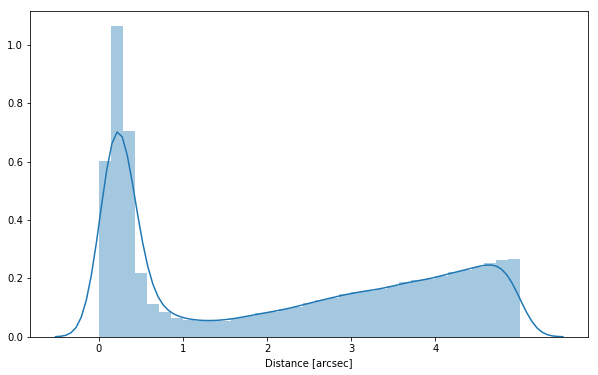

In [34]:
nb_merge_dist_plot(
    SkyCoord(master_catalogue['ra'], master_catalogue['dec']),
    SkyCoord(specz['ra'] * u.deg, specz['dec'] * u.deg)
)

In [35]:
master_catalogue = specz_merge(master_catalogue, specz, radius=1. * u.arcsec)

## VII - Choosing between multiple values for the same filter

### VII.a SERVS vs SWIRE vs CANDELS

Both SERVS and SWIRE provide IRAC1 and IRAC2 fluxes. SERVS is deeper but tends to under-estimate flux of bright sources (Mattia said over 2000 µJy) as illustrated by this comparison of SWIRE, SERVS, and Spitzer-EIP fluxes. On a small section there are also CANDELS forced irac fluxes which since thay are very deep we always take preferentially.

In [36]:
seip = Table.read("../../dmu0/dmu0_SEIP/data/SEIP_CDFS-SWIRE.fits")
seip_coords = SkyCoord(seip['ra'], seip['dec'])
idx, d2d, _ = seip_coords.match_to_catalog_sky(SkyCoord(master_catalogue['ra'], master_catalogue['dec']))
mask = d2d <= 2 * u.arcsec

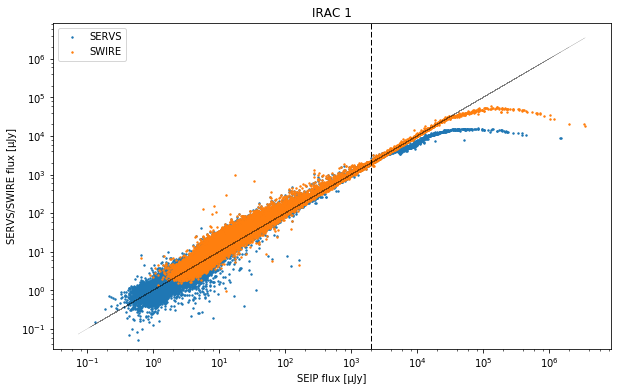

In [37]:
fig, ax = plt.subplots()
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac1'], label="SERVS", s=2.)
ax.scatter(seip['i1_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac1'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 1")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)
ax.plot(seip['i1_f_ap1'][mask], seip['i1_f_ap1'][mask], linewidth=.1, color="black", alpha=.5);

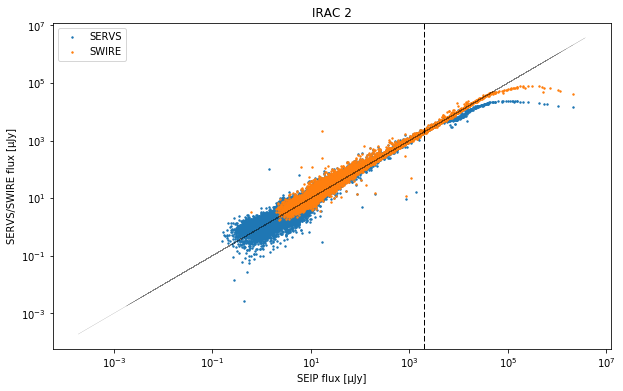

In [38]:
fig, ax = plt.subplots()
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_servs_irac2'], label="SERVS", s=2.)
ax.scatter(seip['i2_f_ap1'][mask], master_catalogue[idx[mask]]['f_ap_swire_irac2'], label="SWIRE", s=2.)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("SEIP flux [μJy]")
ax.set_ylabel("SERVS/SWIRE flux [μJy]")
ax.set_title("IRAC 2")
ax.legend()
ax.axvline(2000, color="black", linestyle="--", linewidth=1.)

ax.plot(seip['i1_f_ap2'][mask], seip['i1_f_ap2'][mask], linewidth=.1, color="black", alpha=.5);

When both SWIRE and SERVS fluxes are provided, we use the SERVS flux below 2000 μJy and the SWIRE flux over.

We create a table indicating for each source the origin on the IRAC1 and IRAC2 fluxes that will be saved separately.

In [39]:
irac_origin = Table()
irac_origin.add_column(master_catalogue['help_id'])

In [40]:
# IRAC1 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac1'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac1'])
has_both = has_servs & has_swire



print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac1'][has_servs] > 2000


use_swire = ((has_swire & ~has_servs) | (has_both & has_servs_above_limit))
use_servs =  ((has_servs & ~(has_both & has_servs_above_limit)))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))


f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_servs] = master_catalogue['f_ap_servs_irac1'][use_servs]
f_ap_irac[use_swire] = master_catalogue['f_ap_swire_irac1'][use_swire]


ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_servs] = master_catalogue['ferr_ap_servs_irac1'][use_servs]
ferr_ap_irac[use_swire] = master_catalogue['ferr_ap_swire_irac1'][use_swire]


m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_servs] = master_catalogue['m_ap_servs_irac1'][use_servs]
m_ap_irac[use_swire] = master_catalogue['m_ap_swire_irac1'][use_swire]


merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_servs] = master_catalogue['merr_ap_servs_irac1'][use_servs]
merr_ap_irac[use_swire] = master_catalogue['merr_ap_swire_irac1'][use_swire]


master_catalogue.add_column(Column(data=f_ap_irac, name="f_ap_irac_i1"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_ap_irac_i1"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_ap_irac_i1"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_ap_irac_i1"))

master_catalogue.remove_columns(['f_ap_servs_irac1', 'f_ap_swire_irac1', 'ferr_ap_servs_irac1',
                                     'ferr_ap_swire_irac1', 'm_ap_servs_irac1', 'm_ap_swire_irac1',
                                     'merr_ap_servs_irac1', 'merr_ap_swire_irac1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"

irac_origin.add_column(Column(data=origin, name="IRAC1_ap"))

620841 sources with SERVS flux
433129 sources with SWIRE flux
247077 sources with SERVS and SWIRE flux
619863 sources for which we use SERVS
187030 sources for which we use SWIRE


In [41]:
# IRAC1 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac1'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac1'])
has_both = has_servs & has_swire

has_candels = ~np.isnan(master_catalogue['f_candels-irac_i1'])

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))
print("{} sources with CANDELS flux".format(np.sum(has_candels)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac1'][has_servs] > 2000

use_candels = has_candels
use_swire = ~has_candels & ((has_swire & ~has_servs) | (has_both & has_servs_above_limit))
use_servs = ~has_candels & ((has_servs & ~(has_both & has_servs_above_limit)))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))
print("{} sources for which we use CANDELS".format(np.sum(use_candels)))

f_irac = np.full(len(master_catalogue), np.nan)
f_irac[use_servs] = master_catalogue['f_servs_irac1'][use_servs]
f_irac[use_swire] = master_catalogue['f_swire_irac1'][use_swire]
f_irac[use_candels] = master_catalogue['f_candels-irac_i1'][use_candels]

ferr_irac = np.full(len(master_catalogue), np.nan)
ferr_irac[use_servs] = master_catalogue['ferr_servs_irac1'][use_servs]
ferr_irac[use_swire] = master_catalogue['ferr_swire_irac1'][use_swire]
ferr_irac[use_candels] = master_catalogue['ferr_candels-irac_i1'][use_candels]

flag_irac = np.full(len(master_catalogue), False, dtype=bool)
flag_irac[use_servs] = master_catalogue['flag_servs_irac1'][use_servs]
flag_irac[use_swire] = master_catalogue['flag_swire_irac1'][use_swire]
flag_irac[use_candels] = master_catalogue['flag_candels-irac_i1'][use_candels]

m_irac = np.full(len(master_catalogue), np.nan)
m_irac[use_servs] = master_catalogue['m_servs_irac1'][use_servs]
m_irac[use_swire] = master_catalogue['m_swire_irac1'][use_swire]
m_irac[use_candels] = master_catalogue['m_candels-irac_i1'][use_candels]

merr_irac = np.full(len(master_catalogue), np.nan)
merr_irac[use_servs] = master_catalogue['merr_servs_irac1'][use_servs]
merr_irac[use_swire] = master_catalogue['merr_swire_irac1'][use_swire]
merr_irac[use_candels] = master_catalogue['merr_candels-irac_i1'][use_candels]

master_catalogue.add_column(Column(data=f_irac, name="f_irac_i1"))
master_catalogue.add_column(Column(data=ferr_irac, name="ferr_irac_i1"))
master_catalogue.add_column(Column(data=m_irac, name="m_irac_i1"))
master_catalogue.add_column(Column(data=merr_irac, name="merr_irac_i1"))
master_catalogue.add_column(Column(data=flag_irac, name="flag_irac_i1"))

master_catalogue.remove_columns(['f_servs_irac1', 'f_swire_irac1', 'ferr_servs_irac1',
                                 'ferr_swire_irac1', 'm_servs_irac1', 'flag_servs_irac1', 'm_swire_irac1',
                                 'merr_servs_irac1', 'merr_swire_irac1', 'flag_swire_irac1',
                                 
                                'f_candels-irac_i1',
                                 'ferr_candels-irac_i1',
                                 'm_candels-irac_i1',
                                 'merr_candels-irac_i1',
                                'flag_candels-irac_i1'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
origin[use_candels] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC1_total"))

620841 sources with SERVS flux
433097 sources with SWIRE flux
247077 sources with SERVS and SWIRE flux
34926 sources with CANDELS flux
614662 sources for which we use SERVS
186876 sources for which we use SWIRE
34926 sources for which we use CANDELS


In [42]:
# IRAC2 aperture flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_ap_servs_irac2'])
has_swire = ~np.isnan(master_catalogue['f_ap_swire_irac2'])
has_both = has_servs & has_swire

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_ap_servs_irac2'][has_servs] > 2000

use_swire = (has_swire & ~has_servs) | (has_both & has_servs_above_limit)
use_servs = (has_servs & ~(has_both & has_servs_above_limit))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))

f_ap_irac = np.full(len(master_catalogue), np.nan)
f_ap_irac[use_servs] = master_catalogue['f_ap_servs_irac2'][use_servs]
f_ap_irac[use_swire] = master_catalogue['f_ap_swire_irac2'][use_swire]

ferr_ap_irac = np.full(len(master_catalogue), np.nan)
ferr_ap_irac[use_servs] = master_catalogue['ferr_ap_servs_irac2'][use_servs]
ferr_ap_irac[use_swire] = master_catalogue['ferr_ap_swire_irac2'][use_swire]

m_ap_irac = np.full(len(master_catalogue), np.nan)
m_ap_irac[use_servs] = master_catalogue['m_ap_servs_irac2'][use_servs]
m_ap_irac[use_swire] = master_catalogue['m_ap_swire_irac2'][use_swire]

merr_ap_irac = np.full(len(master_catalogue), np.nan)
merr_ap_irac[use_servs] = master_catalogue['merr_ap_servs_irac2'][use_servs]
merr_ap_irac[use_swire] = master_catalogue['merr_ap_swire_irac2'][use_swire]

master_catalogue.add_column(Column(data=f_ap_irac, name="f_ap_irac_i2"))
master_catalogue.add_column(Column(data=ferr_ap_irac, name="ferr_ap_irac_i2"))
master_catalogue.add_column(Column(data=m_ap_irac, name="m_ap_irac_i2"))
master_catalogue.add_column(Column(data=merr_ap_irac, name="merr_ap_irac_i2"))

master_catalogue.remove_columns(['f_ap_servs_irac2', 'f_ap_swire_irac2', 'ferr_ap_servs_irac2',
                                 'ferr_ap_swire_irac2', 'm_ap_servs_irac2', 'm_ap_swire_irac2',
                                 'merr_ap_servs_irac2', 'merr_ap_swire_irac2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
irac_origin.add_column(Column(data=origin, name="IRAC2_ap"))

634320 sources with SERVS flux
318895 sources with SWIRE flux
186454 sources with SERVS and SWIRE flux
633670 sources for which we use SERVS
133091 sources for which we use SWIRE


In [43]:
# IRAC2 total flux and magnitudes
has_servs = ~np.isnan(master_catalogue['f_servs_irac2'])
has_swire = ~np.isnan(master_catalogue['f_swire_irac2'])
has_both = has_servs & has_swire

has_candels = ~np.isnan(master_catalogue['f_candels-irac_i2'])

print("{} sources with SERVS flux".format(np.sum(has_servs)))
print("{} sources with SWIRE flux".format(np.sum(has_swire)))
print("{} sources with SERVS and SWIRE flux".format(np.sum(has_both)))
print("{} sources with CANDELS flux".format(np.sum(has_candels)))

has_servs_above_limit = has_servs.copy()
has_servs_above_limit[has_servs] = master_catalogue['f_servs_irac2'][has_servs] > 2000

use_candels = has_candels
use_swire = ~has_candels & ((has_swire & ~has_servs) | (has_both & has_servs_above_limit))
use_servs = ~has_candels & ((has_servs & ~(has_both & has_servs_above_limit)))

print("{} sources for which we use SERVS".format(np.sum(use_servs)))
print("{} sources for which we use SWIRE".format(np.sum(use_swire)))
print("{} sources for which we use CANDELS".format(np.sum(use_candels)))

f_irac = np.full(len(master_catalogue), np.nan)
f_irac[use_servs] = master_catalogue['f_servs_irac2'][use_servs]
f_irac[use_swire] = master_catalogue['f_swire_irac2'][use_swire]
f_irac[use_candels] = master_catalogue['f_candels-irac_i2'][use_candels]

ferr_irac = np.full(len(master_catalogue), np.nan)
ferr_irac[use_servs] = master_catalogue['ferr_servs_irac2'][use_servs]
ferr_irac[use_swire] = master_catalogue['ferr_swire_irac2'][use_swire]
ferr_irac[use_candels] = master_catalogue['ferr_candels-irac_i2'][use_candels]

flag_irac = np.full(len(master_catalogue), False, dtype=bool)
flag_irac[use_servs] = master_catalogue['flag_servs_irac2'][use_servs]
flag_irac[use_swire] = master_catalogue['flag_swire_irac2'][use_swire]
flag_irac[use_candels] = master_catalogue['flag_candels-irac_i2'][use_candels]

m_irac = np.full(len(master_catalogue), np.nan)
m_irac[use_servs] = master_catalogue['m_servs_irac2'][use_servs]
m_irac[use_swire] = master_catalogue['m_swire_irac2'][use_swire]
m_irac[use_candels] = master_catalogue['m_candels-irac_i2'][use_candels]

merr_irac = np.full(len(master_catalogue), np.nan)
merr_irac[use_servs] = master_catalogue['merr_servs_irac2'][use_servs]
merr_irac[use_swire] = master_catalogue['merr_swire_irac2'][use_swire]
merr_irac[use_candels] = master_catalogue['merr_candels-irac_i2'][use_candels]

master_catalogue.add_column(Column(data=f_irac, name="f_irac_i2"))
master_catalogue.add_column(Column(data=ferr_irac, name="ferr_irac_i2"))
master_catalogue.add_column(Column(data=m_irac, name="m_irac_i2"))
master_catalogue.add_column(Column(data=merr_irac, name="merr_irac_i2"))
master_catalogue.add_column(Column(data=flag_irac, name="flag_irac_i2"))

master_catalogue.remove_columns(['f_servs_irac2', 'f_swire_irac2', 'ferr_servs_irac2',
                                 'ferr_swire_irac2', 'm_servs_irac2', 'flag_servs_irac2', 'm_swire_irac2',
                                 'merr_servs_irac2', 'merr_swire_irac2', 'flag_swire_irac2',
                                
                                'f_candels-irac_i2',
                                'ferr_candels-irac_i2',
                                'm_candels-irac_i2',
                                'merr_candels-irac_i2',
                                'flag_candels-irac_i2'])

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[use_servs] = "SERVS"
origin[use_swire] = "SWIRE"
origin[use_candels] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC2_total"))

634320 sources with SERVS flux
318886 sources with SWIRE flux
186454 sources with SERVS and SWIRE flux
34926 sources with CANDELS flux
628496 sources for which we use SERVS
133020 sources for which we use SWIRE
34926 sources for which we use CANDELS


In [44]:
has_candels_irac_i3 = ~np.isnan(master_catalogue['f_candels-irac_i3'])
has_candels_irac_i4 = ~np.isnan(master_catalogue['f_candels-irac_i4'])
has_swire_irac_i3 = ~np.isnan(master_catalogue['f_irac3'])
has_swire_irac_i4 = ~np.isnan(master_catalogue['f_irac4'])

use_candels_irac_i3 = has_candels_irac_i3 & ~has_swire_irac_i3
use_candels_irac_i4 = has_candels_irac_i4 & ~has_swire_irac_i4

for col in master_catalogue.colnames:
    if '_irac3' in col:
        master_catalogue[col].name = col.replace('_irac3', '_irac_i3')
    if '_irac4' in col:
        master_catalogue[col].name = col.replace('_irac4', '_irac_i4')

master_catalogue['f_irac_i3'][use_candels_irac_i3] = master_catalogue['f_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['ferr_irac_i3'][use_candels_irac_i3] = master_catalogue['ferr_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['m_irac_i3'][use_candels_irac_i3] = master_catalogue['m_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['merr_irac_i3'][use_candels_irac_i3] = master_catalogue['merr_candels-irac_i3'][use_candels_irac_i3]
master_catalogue['flag_irac_i3'][use_candels_irac_i3] = master_catalogue['flag_candels-irac_i3'][use_candels_irac_i3]

master_catalogue['f_irac_i4'][use_candels_irac_i3] = master_catalogue['f_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['ferr_irac_i4'][use_candels_irac_i3] = master_catalogue['ferr_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['m_irac_i4'][use_candels_irac_i3] = master_catalogue['m_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['merr_irac_i4'][use_candels_irac_i3] = master_catalogue['merr_candels-irac_i4'][use_candels_irac_i3]
master_catalogue['flag_irac_i4'][use_candels_irac_i3] = master_catalogue['flag_candels-irac_i4'][use_candels_irac_i3]

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_swire_irac_i3] = "SWIRE"
origin[use_candels_irac_i3] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC3_total"))

origin = np.full(len(master_catalogue), '     ', dtype='<U5')
origin[has_swire_irac_i4] = "SWIRE"
origin[use_candels_irac_i4] = "CANDELS"
irac_origin.add_column(Column(data=origin, name="IRAC4_total"))

master_catalogue.remove_columns(['f_candels-irac_i3',    'f_candels-irac_i4',
                                 'ferr_candels-irac_i3', 'ferr_candels-irac_i4',
                                 'm_candels-irac_i3',    'm_candels-irac_i4',
                                 'merr_candels-irac_i3', 'merr_candels-irac_i4',
                                 'flag_candels-irac_i3', 'flag_candels-irac_i4'])

In [45]:
irac_origin.write("{}/cdfs-swire_irac_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## VII.b VIDEO vs VHS
VIDEO is deeper than VHS so we take VIDEO flux for any source that has both.

In [46]:
vista_origin = Table()
vista_origin.add_column(master_catalogue['help_id'])

In [47]:
vista_bands = ['y','j','h','k'] # Lowercase naming convention (k is Ks)
for band in vista_bands:
    print('For VISTA band ' + band + ':')
    # VISTA total flux 
    has_video = ~np.isnan(master_catalogue['f_video_' + band])
    has_vhs = ~np.isnan(master_catalogue['f_vhs_' + band])
    has_both = has_video & has_vhs

    print("{} sources with VIDEO flux".format(np.sum(has_video)))
    print("{} sources with VHS flux".format(np.sum(has_vhs)))
    print("{} sources with VIDEO and VHS flux".format(np.sum(has_both)))


    use_video = has_video 
    use_vhs = has_vhs & ~has_both

    print("{} sources for which we use VIDEO".format(np.sum(use_video)))
    print("{} sources for which we use VHS".format(np.sum(use_vhs)))

    f_vista = np.full(len(master_catalogue), np.nan)
    f_vista[use_video] = master_catalogue['f_video_' + band][use_video]
    f_vista[use_vhs] = master_catalogue['f_vhs_' + band][use_vhs]

    ferr_vista = np.full(len(master_catalogue), np.nan)
    ferr_vista[use_video] = master_catalogue['ferr_video_' + band][use_video]
    ferr_vista[use_vhs] = master_catalogue['ferr_vhs_' + band][use_vhs]
    
    m_vista = np.full(len(master_catalogue), np.nan)
    m_vista[use_video] = master_catalogue['m_video_' + band][use_video]
    m_vista[use_vhs] = master_catalogue['m_vhs_' + band][use_vhs]

    merr_vista = np.full(len(master_catalogue), np.nan)
    merr_vista[use_video] = master_catalogue['merr_video_' + band][use_video]
    merr_vista[use_vhs] = master_catalogue['merr_vhs_' + band][use_vhs]

    flag_vista = np.full(len(master_catalogue), False, dtype=bool)
    flag_vista[use_video] = master_catalogue['flag_video_' + band][use_video]
    flag_vista[use_vhs] = master_catalogue['flag_vhs_' + band][use_vhs]

    master_catalogue.add_column(Column(data=f_vista, name="f_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_vista, name="ferr_vista_" + band))
    master_catalogue.add_column(Column(data=m_vista, name="m_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_vista_" + band))
    master_catalogue.add_column(Column(data=flag_vista, name="flag_vista_" + band))

    master_catalogue.remove_columns(['f_video_' + band, 
                                     'f_vhs_' + band, 
                                     'ferr_video_' + band,
                                     'ferr_vhs_' + band, 
                                     'm_video_' + band, 
                                     'm_vhs_' + band, 
                                     'merr_video_' + band,
                                     'merr_vhs_' + band,
                                     'flag_video_' + band, 
                                     'flag_vhs_' + band])

    origin = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin[use_video] = "VIDEO"
    origin[use_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin, name= 'f_vista_' + band ))
    
    
    
    # VISTA Aperture flux
    has_ap_video = ~np.isnan(master_catalogue['f_ap_video_' + band])
    has_ap_vhs = ~np.isnan(master_catalogue['f_ap_vhs_' + band])
    has_ap_both = has_ap_video & has_ap_vhs

    print("{} sources with VIDEO aperture flux".format(np.sum(has_ap_video)))
    print("{} sources with VHS aperture flux".format(np.sum(has_ap_vhs)))
    print("{} sources with VIDEO and VHS aperture flux".format(np.sum(has_ap_both)))


    use_ap_video = has_ap_video 
    use_ap_vhs = has_ap_vhs & ~has_ap_both

    print("{} sources for which we use VIDEO aperture fluxes".format(np.sum(use_ap_video)))
    print("{} sources for which we use VHS aperture fluxes".format(np.sum(use_ap_vhs)))

    f_ap_vista = np.full(len(master_catalogue), np.nan)
    f_ap_vista[use_ap_video] = master_catalogue['f_ap_video_' + band][use_ap_video]
    f_ap_vista[use_ap_vhs] = master_catalogue['f_ap_vhs_' + band][use_ap_vhs]

    ferr_ap_vista = np.full(len(master_catalogue), np.nan)
    ferr_ap_vista[use_ap_video] = master_catalogue['ferr_ap_video_' + band][use_ap_video]
    ferr_ap_vista[use_ap_vhs] = master_catalogue['ferr_ap_vhs_' + band][use_ap_vhs]
    
    m_ap_vista = np.full(len(master_catalogue), np.nan)
    m_ap_vista[use_ap_video] = master_catalogue['m_ap_video_' + band][use_ap_video]
    m_ap_vista[use_ap_vhs] = master_catalogue['m_ap_vhs_' + band][use_ap_vhs]

    merr_ap_vista = np.full(len(master_catalogue), np.nan)
    merr_ap_vista[use_ap_video] = master_catalogue['merr_ap_video_' + band][use_ap_video]
    merr_ap_vista[use_ap_vhs] = master_catalogue['merr_ap_vhs_' + band][use_ap_vhs]


    master_catalogue.add_column(Column(data=f_ap_vista, name="f_ap_vista_" + band))
    master_catalogue.add_column(Column(data=ferr_ap_vista, name="ferr_ap_vista_" + band))
    master_catalogue.add_column(Column(data=m_ap_vista, name="m_ap_vista_" + band))
    master_catalogue.add_column(Column(data=merr_vista, name="merr_ap_vista_" + band))


    master_catalogue.remove_columns(['f_ap_video_' + band, 
                                     'f_ap_vhs_' + band, 
                                     'ferr_ap_video_' + band,
                                     'ferr_ap_vhs_' + band,
                                     'm_ap_video_' + band, 
                                     'm_ap_vhs_' + band, 
                                     'merr_ap_video_' + band,
                                     'merr_ap_vhs_' + band])

    origin_ap = np.full(len(master_catalogue), '     ', dtype='<U5')
    origin_ap[use_ap_video] = "VIDEO"
    origin_ap[use_ap_vhs] = "VHS"
    
    vista_origin.add_column(Column(data=origin_ap, name= 'f_ap_vista_' + band ))
                  

For VISTA band y:
1063464 sources with VIDEO flux
14179 sources with VHS flux
10792 sources with VIDEO and VHS flux
1063464 sources for which we use VIDEO
3387 sources for which we use VHS
1061411 sources with VIDEO aperture flux
14179 sources with VHS aperture flux
10791 sources with VIDEO and VHS aperture flux
1061411 sources for which we use VIDEO aperture fluxes
3388 sources for which we use VHS aperture fluxes
For VISTA band j:
1061794 sources with VIDEO flux
105677 sources with VHS flux
31304 sources with VIDEO and VHS flux
1061794 sources for which we use VIDEO
74373 sources for which we use VHS
1058115 sources with VIDEO aperture flux
105674 sources with VHS aperture flux
31305 sources with VIDEO and VHS aperture flux
1058115 sources for which we use VIDEO aperture fluxes
74369 sources for which we use VHS aperture fluxes
For VISTA band h:
1051715 sources with VIDEO flux
82037 sources with VHS flux
25260 sources with VIDEO and VHS flux
1051715 sources for which we use VIDEO
567

In [48]:
      
#Z band only in VIDEO
               
master_catalogue['f_ap_video_z'].name = 'f_ap_vista_z'
master_catalogue['ferr_ap_video_z'].name = 'ferr_ap_vista_z'
master_catalogue['f_video_z'].name = 'f_vista_z'
master_catalogue['ferr_video_z'].name = 'ferr_vista_z'
master_catalogue['m_ap_video_z'].name = 'm_ap_vista_z'
master_catalogue['merr_ap_video_z'].name = 'merr_ap_vista_z'
master_catalogue['m_video_z'].name = 'm_vista_z'
master_catalogue['merr_video_z'].name = 'merr_vista_z'
master_catalogue['flag_video_z'].name = 'flag_vista_z'

In [49]:
vista_origin.write("{}/cdfs-swire_vista_fluxes_origins{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)

## VIII.a Wavelength domain coverage

We add a binary `flag_optnir_obs` indicating that a source was observed in a given wavelength domain:

- 1 for observation in optical;
- 2 for observation in near-infrared;
- 4 for observation in mid-infrared (IRAC).

It's an integer binary flag, so a source observed both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: The observation flag is based on the creation of multi-order coverage maps from the catalogues, this may not be accurate, especially on the edges of the coverage.*

*Note 2: Being on the observation coverage does not mean having fluxes in that wavelength domain. For sources observed in one domain but having no flux in it, one must take into consideration de different depths in the catalogue we are using.*

In [50]:
atlas_moc = MOC(filename="../../dmu0/dmu0_ATLAS/data/ATLAS_CDFS-SWIRE_MOC.fits")
combo_moc = MOC(filename="../../dmu0/dmu0_COMBO-17/data/table3_MOC.fits")
#fireworks_moc = MOC(filename="../../dmu0/dmu0_Fireworks/data/Fireworks_MOC.fits")
ps1_moc = MOC(filename="../../dmu0/dmu0_PanSTARRS1-3SS/data/PanSTARRS1-3SS_CDFS-SWIRE_MOC.fits")
servs_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SERVS_CDFS-SWIRE_MOC.fits")
swire_moc = MOC(filename="../../dmu0/dmu0_DataFusion-Spitzer/data/DF-SWIRE_CDFS-SWIRE_MOC.fits")
video_moc= MOC(filename="../../dmu0/dmu0_VISTA-VIDEO-private/data/VIDEO-all_2017-02-12_fullcat_errfix_CDFS-SWIRE_MOC.fits")
vhs_moc= MOC(filename="../../dmu0/dmu0_VISTA-VHS/data/VHS_CDFS-SWIRE_MOC.fits")
des_moc =MOC(filename="../../dmu0/dmu0_DES/data/DES-DR1_CDFS-SWIRE_MOC.fits")
candels_moc =MOC(filename="../../dmu0/dmu0_CANDELS-GOODS-S/data/hlsp_candels_hst_wfc3_goodss-tot-multiband_f160w_v1_MOC.fits")

In [51]:
was_observed_optical = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    ps1_moc + atlas_moc + combo_moc + des_moc + candels_moc ) #+ fireworks_moc

was_observed_nir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    vhs_moc + video_moc
)

was_observed_mir = inMoc(
    master_catalogue['ra'], master_catalogue['dec'],
    servs_moc + swire_moc
)

In [52]:
master_catalogue.add_column(
    Column(
        1 * was_observed_optical + 2 * was_observed_nir + 4 * was_observed_mir,
        name="flag_optnir_obs")
)

## VIII.b Wavelength domain detection

We add a binary `flag_optnir_det` indicating that a source was detected in a given wavelength domain:

- 1 for detection in optical;
- 2 for detection in near-infrared;
- 4 for detection in mid-infrared (IRAC).

It's an integer binary flag, so a source detected both in optical and near-infrared by not in mid-infrared would have this flag at 1 + 2 = 3.

*Note 1: We use the total flux columns to know if the source has flux, in some catalogues, we may have aperture flux and no total flux.*

To get rid of artefacts (chip edges, star flares, etc.) we consider that a source is detected in one wavelength domain when it has a flux value in **at least two bands**. That means that good sources will be excluded from this flag when they are on the coverage of only one band.

In [53]:
# SpARCS is a catalogue of sources detected in r (with fluxes measured at 
# this prior position in the other bands).  Thus, we are only using the r
# CFHT band.
# Check to use catalogue flags from HSC and PanSTARRS.
nb_optical_flux = (
    1 * ~np.isnan(master_catalogue['f_ps1_g']) +
    1 * ~np.isnan(master_catalogue['f_ps1_r']) +
    1 * ~np.isnan(master_catalogue['f_ps1_i']) +
    1 * ~np.isnan(master_catalogue['f_ps1_z']) +
    1 * ~np.isnan(master_catalogue['f_ps1_y']) +
    
    1 * ~np.isnan(master_catalogue['f_atlas_u']) +
    1 * ~np.isnan(master_catalogue['f_atlas_g']) +
    1 * ~np.isnan(master_catalogue['f_atlas_r']) +
    1 * ~np.isnan(master_catalogue['f_atlas_i']) +
    1 * ~np.isnan(master_catalogue['f_atlas_z']) +
    #DES
    1 * ~np.isnan(master_catalogue['f_decam_g']) +
    1 * ~np.isnan(master_catalogue['f_decam_r']) +    
    1 * ~np.isnan(master_catalogue['f_decam_i']) +
    1 * ~np.isnan(master_catalogue['f_decam_z']) +
    1 * ~np.isnan(master_catalogue['f_decam_y']) 

)

nb_nir_flux = (

    1 * ~np.isnan(master_catalogue['f_vista_y']) +
    1 * ~np.isnan(master_catalogue['f_vista_h']) +
    1 * ~np.isnan(master_catalogue['f_vista_j']) +
    1 * ~np.isnan(master_catalogue['f_vista_k'])
)

nb_mir_flux = (
    1 * ~np.isnan(master_catalogue['f_irac_i1']) +
    1 * ~np.isnan(master_catalogue['f_irac_i2']) +
    1 * ~np.isnan(master_catalogue['f_irac_i3']) +
    1 * ~np.isnan(master_catalogue['f_irac_i4'])
)

In [54]:
has_optical_flux = nb_optical_flux >= 2
has_nir_flux = nb_nir_flux >= 2
has_mir_flux = nb_mir_flux >= 2

master_catalogue.add_column(
    Column(
        1 * has_optical_flux + 2 * has_nir_flux + 4 * has_mir_flux,
        name="flag_optnir_det")
)

## IX - Cross-identification table
We are producing a table associating to each HELP identifier, the identifiers of the sources in the pristine catalogues. This can be used to easily get additional information from them.

In [55]:
id_names = []
for col in master_catalogue.colnames:
    if '_id' in col:
        id_names += [col]
    if '_intid' in col:
        id_names += [col]
        
print(id_names)

['ps1_id', 'combo_id', 'atlas_id', 'video_id', 'vhs_id', 'servs_intid', 'swire_intid', 'des_id', 'candels_id', 'help_id', 'specz_id']


In [56]:
master_catalogue[id_names].write(
    "{}/master_list_cross_ident_cdfs-swire{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)
id_names.remove('help_id')
master_catalogue.remove_columns(id_names)

## X - Adding HEALPix index

We are adding a column with a HEALPix index at order 13 associated with each source.

In [57]:
master_catalogue.add_column(Column(
    data=coords_to_hpidx(master_catalogue['ra'], master_catalogue['dec'], order=13),
    name="hp_idx"
))

## XI - Renaming columns

We rename some columns to follow the intrument_filter standard.

In [58]:
# PanSTARRS: The column name must use the instrument name gpc1
for col in master_catalogue.colnames:
        if 'ps1' in col:
            master_catalogue[col].name = col.replace("ps1", "gpc1")

In [59]:
# COMBO-17: The instrument name is wfi
new_name = {
    'combo_420': "wfi_416nm",
    'combo_462': "wfi_461nm",
    'combo_485': "wfi_485nm",
    'combo_518': "wfi_518nm",
    'combo_571': "wfi_571nm",
    'combo_604': "wfi_604nm",
    'combo_646': "wfi_646nm",
    'combo_696': "wfi_696nm",
    'combo_753': "wfi_753nm",
    'combo_815': "wfi_815nm",
    'combo_856': "wfi_856nm",
    'combo_914': "wfi_914nm",
    'combo_b': "wfi_b",
    'combo_i': "wfi_i",
    'combo_r': "wfi_r",
    'combo_u': "wfi_u",
    'combo_v': "wfi_v"
}

for col in master_catalogue.colnames:
    if 'combo' in col:
        for old_name in new_name:
            if old_name in col:
                master_catalogue[col].name = col.replace(old_name, new_name[old_name])

In [60]:
# ATLAS: The instrument is omegacam
# The catalogue contains a "UL" band that is not described anywhere except with
# “Bandpass UL comes from CASU created list driven measurement”. We are removing it.
master_catalogue.remove_columns(['m_ap_atlas_ul', 'merr_ap_atlas_ul', 'm_atlas_ul', 'merr_atlas_ul',
                                 'f_ap_atlas_ul', 'ferr_ap_atlas_ul', 'f_atlas_ul', 'ferr_atlas_ul',
                                 'flag_atlas_ul'])
for col in master_catalogue.colnames:
        if 'atlas' in col:
            master_catalogue[col].name = col.replace("atlas", "omegacam")

In [61]:
# VISTA: The instrument is vircam but vista is used in the filter names.
# The K band is in fact a Ks one.
for col in master_catalogue.colnames:
        if 'vista_k' in col:
            master_catalogue[col].name = col.replace("vista_k", "vista_ks")

## XII - Saving the catalogue

In [62]:
columns = ["help_id", "field", "ra", "dec", "hp_idx"]

bands = [column[5:] for column in master_catalogue.colnames if 'f_ap' in column]


bands_no_ap = (set([column[5:] for column in master_catalogue.colnames if 'flag' in column]) 
               - set(bands) 
               - set(['cleaned', 'gaia', 'merged', 'optnir_det', 'optnir_obs', '_association_flag'])
              )


for band in bands:
    columns += ["f_ap_{}".format(band), "ferr_ap_{}".format(band),
                "m_ap_{}".format(band), "merr_ap_{}".format(band),
                "f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                #"flag_{}".format(band)
               ]    

for band in bands_no_ap:
    columns += ["f_{}".format(band), "ferr_{}".format(band),
                "m_{}".format(band), "merr_{}".format(band),
                #"flag_{}".format(band)
               ]   
    
columns += ["stellarity", "stellarity_origin", "flag_cleaned", "flag_merged", "flag_gaia", "flag_optnir_obs", "flag_optnir_det",
            "zspec", "zspec_qual", "zspec_association_flag", "ebv"]

In [63]:
# We check for columns in the master catalogue that we will not save to disk.
print("Missing columns: {}".format(set(master_catalogue.colnames) - set(columns)))

Missing columns: {'flag_wfi_571nm', 'flag_vista_h', 'flag_acs_f775w', 'flag_omegacam_i', 'flag_decam_r', 'flag_wfc3_f125w', 'flag_vista_j', 'flag_wfc3_f105w', 'flag_irac_i3', 'flag_wfi_815nm', 'flag_wfi_485nm', 'flag_wfi_416nm', 'flag_omegacam_g', 'flag_irac_i4', 'flag_omegacam_r', 'flag_wfi_461nm', 'flag_vista_ks', 'flag_gpc1_i', 'flag_decam_g', 'flag_gpc1_r', 'flag_decam_y', 'flag_acs_f435w', 'flag_acs_f850lp', 'flag_wfi_604nm', 'flag_wfc3_f160w', 'flag_wfc3_f098m', 'flag_hawki_k', 'flag_wfi_u', 'flag_decam_i', 'flag_wfi_914nm', 'flag_gpc1_g', 'flag_gpc1_z', 'flag_acs_f606w', 'flag_wfi_856nm', 'flag_irac_i1', 'flag_wfi_646nm', 'flag_vista_z', 'flag_wfi_v', 'flag_isaac_k', 'flag_decam_z', 'flag_wfi_i', 'flag_irac_i2', 'flag_acs_f814w', 'flag_wfi_r', 'flag_vista_y', 'flag_wfi_753nm', 'flag_wfi_518nm', 'flag_gpc1_y', 'flag_omegacam_u', 'flag_wfi_b', 'flag_omegacam_z', 'flag_wfi_696nm'}


In [64]:
master_catalogue[columns].write("{}/master_catalogue_cdfs-swire{}.fits".format(OUT_DIR, SUFFIX), overwrite=True)